# Basics of Precise Radial Velocities, and Performing CCF

Created by Sharon Xuesong Wang, August 9, 2019
Written by Sharon Xuesong Wang and Tianjun Gan

This is a tutorial for getting to know the basics of precise radial velocities, such as how to get RV using the CCF method, the correlation of RV precision vs. resolution and SNR, and so on.

In [2]:
# import the necessary packages
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import matplotlib.gridspec as gridspec
from scipy import interpolate
from scipy.optimize import fmin
import emcee
import corner
%matplotlib inline 

## Doppler Shifting a Spectrum

Let's start with getting a 5 Angstrom chunk of synthetic solar spectrum, which is about the length of a spectral order, and manipulate it to get ourselves familiar with Doppler-shifting a spectrum.

Read in the synthetic solar spectrum here:

In [3]:
os.chdir('../synspec')
specdata=np.load('Kurucz_Sun.npz')
wavelength=specdata['arr_0']
flux=specdata['arr_1']

Grab a chunk between 5200 and 5205 Angstroms, which is the richest region in terms of Doppler information in the Sun.

We will come back to the point of "Doppler information" later.

In [4]:
w_chunk=wavelength[(wavelength>=520) & (wavelength<=520.5)]
f=flux[(wavelength>=520) & (wavelength<=520.5)]

Now, Doppler shift this chunk of spectrum by 27201 m/s.

**Convention of Doppler Shift**: This is a positive number, which means the source is redshifted relative to the observatory frame. The convention is that a blueshift, or object moving towards the observer, will have a negative redshift (thus negative RV).

Why such a large number? The Earth is going around the Sun at ~30 km/s, so any stellar spectrum you see will have
a relative Doppler shift from this motion from its spectrum taken at another epoch. This is called the barycentric (BC) shift. For stars near the celestial equator, for example, the BC shift will swing a full span of from -30 km/s to 30 km/s over the course of a year.

Important points when you are doing a Doppler shift:

- Don't forget to define the speed of light! And do it very very precisely! Do not use $3 \times 10^8$ m/s.
- A Doppler shift is not linear in wavelength space - you do not add a number. It's like a stretch. You stretch the wavelength array $w$ by doing $w\times (1+z)$.

In [5]:
c=2.99792458E8 #light speed in m/s
v_rad=27201    #m/s
z=v_rad/c
z_correct=z
w_observed=w_chunk*(1+z)

Plot the original spectrum and the shifted one next to each other.

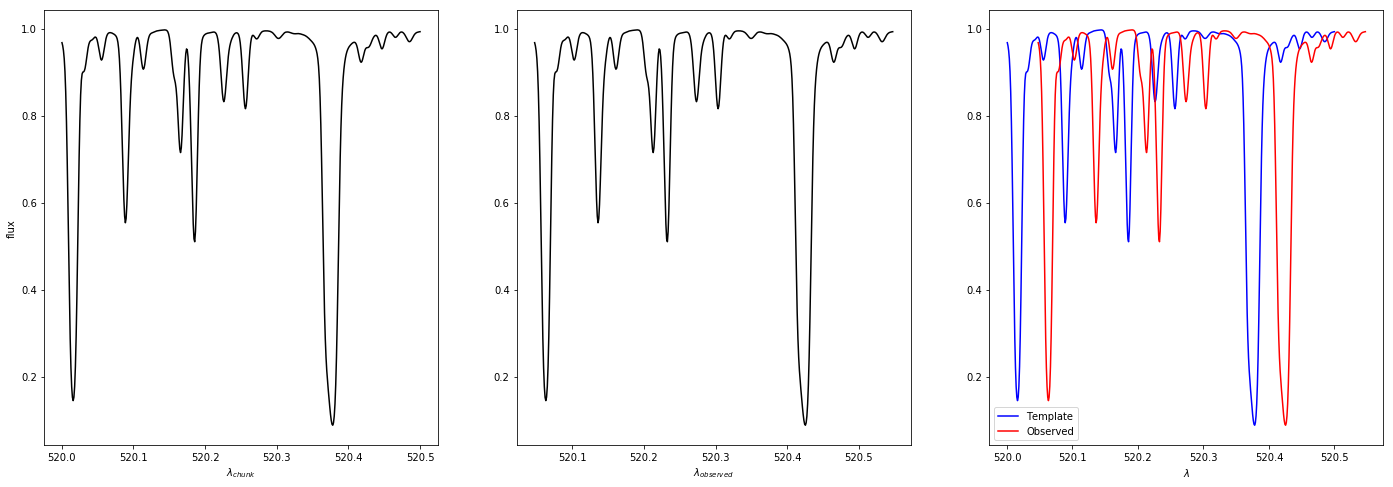

In [5]:
fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax1.plot(w_chunk,f,'k-')
ax2.plot(w_observed, f,'k-')
ax3.plot(w_chunk,f,'b-')
ax3.plot(w_observed, f,'r-')
ax3.legend(['Template','Observed'])
ax1.set_xlabel('$\lambda_{chunk}$')
ax2.set_xlabel('$\lambda_{observed}$')
ax3.set_xlabel('$\lambda$')
ax1.set_ylabel('flux')
plt.show()

## Simplest CCF

Now, the shifted spectrum is your "observed" spectrum. Our next task would be to try to get the RV of this observed spectrum with CCF using the "stellar template", which is the original spectrum before the shift (note: this stellar template has a wider wavelength span than your order of shifted spectrum, so we don't have to worry about edge effects). 

Note: Some people use a mask instead of a stellar template (Baranne et al. 1996) then fit a Gaussian to the CCF - it's mathematically equivalent with using a spectrum (with a Gaussian line profile) to perform the CCF and obtain the minima/maxima of the CCF (credit: David Hogg).

Our eventual goal is to obtain the CCF as a function of redshift $z$, and then find the minima of the CCF, which would be your reported $z$. **Important**: You have to fit the redsfhit $z$ instead of the RV! This is because **$z$ is what you are actually measuring, not the relative RV** between your stellar template and your observed template. To translate $z$ into RV, you need to perform the barycentric correction, which involves relativistic terms so a simple $z = RV/c$ does not work.

The first thing is to create an array of $z$ values. Think carefully about what min and max values should you give this array of $z$ when it comes to real observations.

In [6]:
#For z, at first I chose -(3E4)/c ~ (3E4)/c only consider about the BC shift
z_max=(3E4)/c
z_min=(-3E4)/c
print(z_max)
print(z_min)
z_list=np.linspace(z_min,z_max,200)
z_example= 9E-5
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)]
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]

0.000100069228559
-0.000100069228559


Next, for each $z$ value, you would need to shift your stellar template spectrum to this $z$, and then you want to interpolate your spectrum so that it is evaluated at the same array of wavelenghs as your observed spectrum in order to perform CCF (i.e., same abscissa). Write a function to perform this shift and interpolation.

Make sure to use cubic spline interpolation, not linear.

In fact, neither cubic spline nor linear interpolation conserves flux and therefore Doppler shift. At the sampling rate of our synthetic spectrum, cubic spline does a good enough job that we can ignore this. Very often, when you are working with spectrum with relatively low sampling, you want to up-sample your spectrum first before doing interpolation. Let's don't worry about it right now.

In [7]:
def spec_interpolation(z,w1,flux,w2):   #w1:template wavelength, w2:predicted wavelength
    w1_correction=w1*(1+z)
    f = interpolate.interp1d(w1_correction,flux,kind='cubic')
    #f = interpolate.interp1d(w1_correction,flux)
    flux_pred = f(w2)
    return flux_pred

Check your shift+interpolation function out by plotting a zoomed in chunk of spectrum before and after the operation.

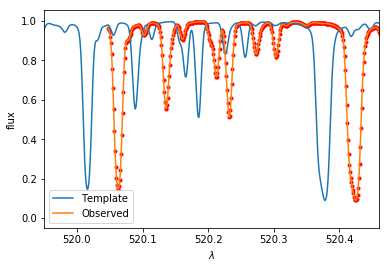

In [8]:
#Example#
z_example= 9E-5
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)]
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]
#print(w_template)
#print(w_emitted)
#exit()
flux_pred = spec_interpolation(z_example,w_template,f_template,w_observed)
plt.figure()
plt.plot(wavelength,flux)
plt.plot(w_observed,flux_pred)
plt.legend(['Template','Observed'])
plt.scatter(w_observed,flux_pred,color='red',marker='.')
plt.xlim(519.95,520.46)
plt.xlabel('$\lambda$')
plt.ylabel('flux')
plt.show()

Now, write a loop to evaluate the CCF at every $z$ value in your $z$ array.

**Important Caution**: Some people like to use the simpler version of CCF, which is $\sum{s*f}$, where $s$ and $f$ are the two functions you are performing CCF on. However, this is wrong in our context. The formal CCF is really $\sum{(s-f)^2}$, and when you have a constant $\sum{s^2}$ and $\sum{f^2}$, you can just use the cross term. However, this is not true in our case! When we are shifting the stellar template spectrum around within the wavelength window of the observed spectrum, on the edge, some portion will be shifted in and out. So your template spectrum $s$ actually changes every time you use a different $z$, so $\sum{s^2}$ is not constant! 

In [21]:
ccf_list=[]
for z in z_list:
    CCF = np.sum((spec_interpolation(z,w_template,f_template,w_observed)-f)**2)
    ccf_list=np.append(ccf_list,[CCF],axis=0)
    print(CCF)
print(ccf_list)

46.23863178139102
45.7238584792959
45.22280589280739
44.73828219040699
44.27226661946908
43.826839955589605
43.40329935613324
43.00309726814848
42.626977035391526
42.27584421927777
41.94996604909964
41.64981153075233
41.375222652054894
41.126198559363935
40.9020419383816
40.702135434139755
40.52494465725277
40.368789344049475
40.23096007689084
40.10861329902879
39.99764597800272
39.893587723152024
39.79100510381314
39.684558213796805
39.568332803959855
39.43692719980496
39.28516473903498
39.10913486574118
38.90564440237257
38.67309496561887
38.410823291604714
38.1197969031195
37.80170275440146
37.4595445562625
37.09675469938772
36.71775703859829
36.32712441237244
35.93009357524633
35.53184546943048
35.137946383635125
34.75373334278891
34.38466355447643
34.03582606212534
33.71221335363305
33.41832341047461
33.15836740001231
32.93598538814937
32.7544024132198
32.61621314923469
32.52349266739561
32.477645114910054
32.47947376354578
32.529093557201705
32.62596177699396
32.768840793677796
3

Plot your CCF vs. z.

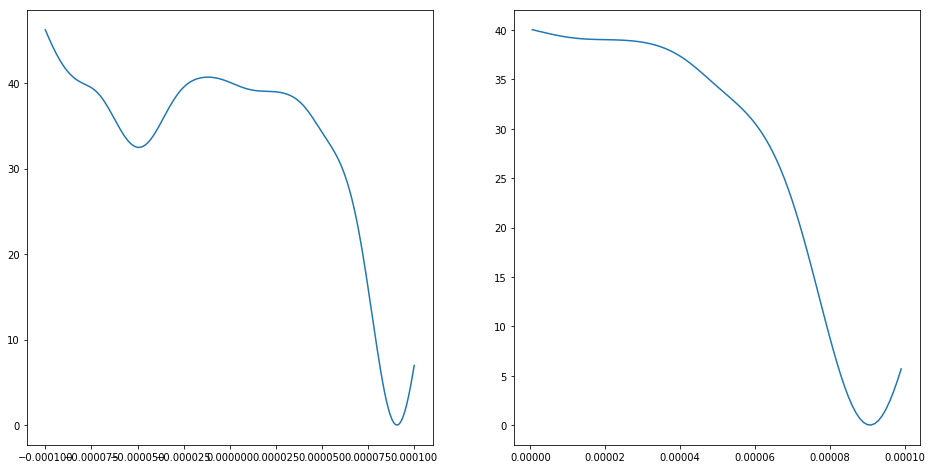

In [22]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.plot(z_list,ccf_list)
ax2.plot(z_list[(z_list<10E-5) & (z_list>0)],ccf_list[(z_list<10E-5) & (z_list>0)])
plt.show()

Write a function to find the minima of your CCF robustly.
Note: Do not fit a Gaussian to the CCF. When using a mask to derive CCF, one should fit a gaussian (i.e. average line profile). But since we are using a stellar template here, we should simply find the minimum of the CCF.

In [23]:
#z_chosen=z_list[(z_list<10E-5) & (z_list>-1E-5)]
#ccf_chosen=ccf_list[(z_list<10E-5) & (z_list>-1E-5)]
#print(min(ccf_chosen))
ccf_min = min(ccf_list)
ccf_min_index = np.argmin(ccf_list,axis=0)
z_expected = z_list[ccf_min_index]

#result#
print ("z_espected=%s"%(z_expected))
print ("z_correct=%s"%(z_correct))


z_espected=9.101774054904351e-05
z_correct=9.07327695348e-05


Now you have a measured z! Is it correct? How many m/s are you away from the correct answer, if any?

In [24]:
#Note that the vrad_err is related to z values array setting. More points, result will be better#
#Comparison: if I set z_list=np.linspace(z_min,z_max,100), vrad_err ~ 230 m/s #
zerror=np.abs(z_expected-z_correct)
vrad_err=zerror*c
print("vrad_err=%s m/s"%(vrad_err))

vrad_err=85.43216080402627 m/s


# RV precision vs. spectral resolution

Great! You've measured the Doppler shift. If everything goes well, you should get almost exact the same answer as the input $z$. Of course we had a idealized case where there was no noise, and also the piece of spectrum we used was at basically infinite resolution and a very high sampling rate. In reality, we would never have such spectra from observations. 

In the following sections, we will explore how RV precision depends on things like spectral resolution and SNR. Let's start with spectral resolution first.

## Convolve spectrum with a PSF

Let's first convolve a chunk of stellar template or input synthetic spectrum with a PSF that corresponds to a spectral resolution of $R=120,000$, fairly common for modern PRV instrument.

We are going to assume that the spectral PSF (also known as the Intrumental Profile or IP, or the spectrograph response function or SRF) takes a symmetric Gaussian shape. This is again never true in reality, but for our purpose of figuring out RV precision vs. resolution, this will suffice.

Now, here are the steps for convolving a spectrum down to any given resolution:
1. Figure out the dispersion scale of your spectrum:
$\delta_\lambda = \overset{\circ}{A}$ per pixel of your observed spectrum

2. Assuming your resolution is $R$ at wavelength $\lambda$, figure out the resolution element in \AA:
$FWHM_\lambda = \lambda / R$ (unit = $\overset{\circ}{A}$), 
which is assuming your resolving power is set by the FWHM of the Gaussian PSF. 

3. Because the FWHM of a Gaussian = 2.3548*$\sigma$:
$\sigma_\lambda = FWHM_\lambda/2.3548$ (unit = $\overset{\circ}{A}$)

4. Now, what's the width of your Gaussian in pixel space:
$\sigma_{pixel} = \sigma_\lambda / \delta_\lambda$ (unit = pixel)

5. If the sampling factor of your original spectrum is not very high, then I would recommend up-sample your spectrum first, then convolve, and then down-sample it back to the original wavelength scale. In our case, the synthetic spectrum has a pretty high sampling rate, so there is no need to do this (although the wavelength grid is not perfectly even, which would just mean that our resolution would change a bit, but that's ok). As up-sampling and down-sampling is not as easy as interpolation back and forth due to the need to conserve flux (and thus Doppler shift), let's not get into that for now. But if you are interested, you can check out this post on AstroBetter (note that the python package has changed quite a bit, but if you read the docs you'd figure out how to use it):
https://www.astrobetter.com/blog/2013/08/12/python-tip-re-sampling-spectra-with-pysynphot/

Now, please go head and write a function to do this, and convolve the spectrum down to $R=120,000$.

In [24]:
def psf(w,wavelength,resolution):
    fwhm_lambda = wavelength / resolution
    sigma_lambda = fwhm_lambda / 2.3548
    return (1.0/(np.sqrt(2*np.pi)*sigma_lambda))*np.exp(-(w-wavelength)**2/(2*sigma_lambda**2))
    
flux_total=[0 for x in range(0, len(w_template))]
w_template=wavelength[(wavelength>519.8) & (wavelength<520.6)] * 10    #in A
f_template=flux[(wavelength>519.8) & (wavelength<520.6)]

R = 120000   
for i in range(len(w_template)):
    flux_total+=np.convolve(f_template[i],psf(w_template,w_template[i],R))

Then plot the original spectrum vs. the broadened spectrum. 

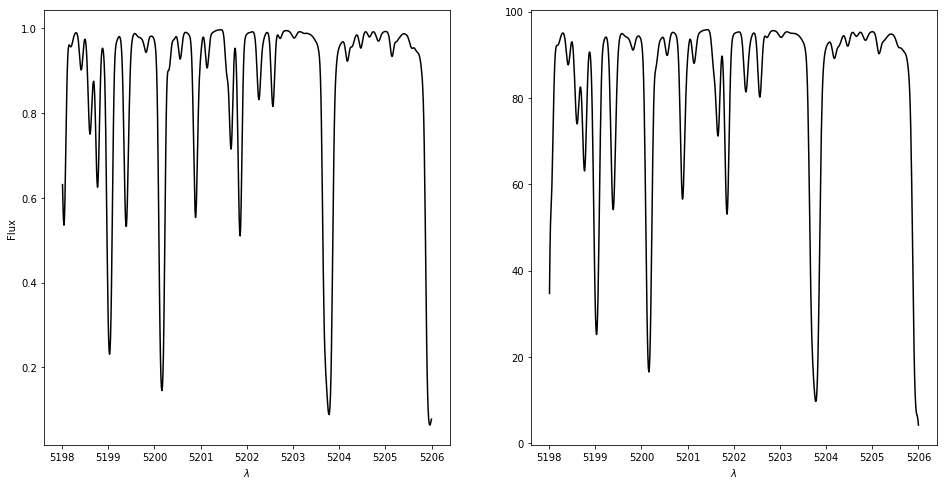

In [25]:
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.plot(w_template,f_template,'k-')
ax2.plot(w_template, flux_total,'k-')
ax1.set_xlabel('$\lambda$')
ax2.set_xlabel('$\lambda$')
ax1.set_ylabel('Flux')
plt.show()

Huh! They almost look identical! Did you see that coming? ;)
This is because the solar spectrum is dominated by rotation broadening, so the lines are already fully resolved at this high resolution of $R=120,000$. Explore a few different lower resolution values and see when you would start seeing an obvious broadening of the stellar spectrum (say, from $R=10,000$). 

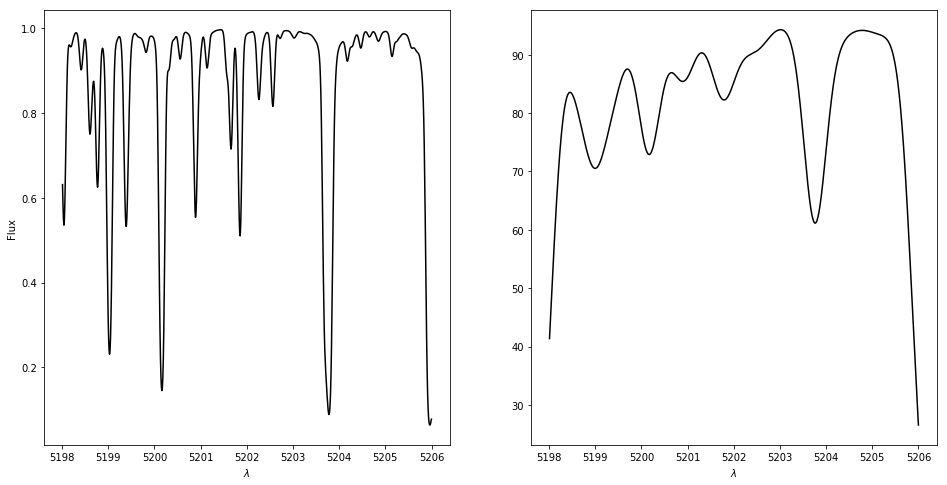

In [26]:
R = 10000
flux_total=[0 for x in range(0, len(w_template))]
for i in range(len(w_template)):
    flux_total+=np.convolve(f_template[i],psf(w_template,w_template[i],R))
fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax1.plot(w_template,f_template,'k-')
ax2.plot(w_template, flux_total,'k-')
ax1.set_xlabel('$\lambda$')
ax2.set_xlabel('$\lambda$')
ax1.set_ylabel('Flux')
plt.show()